# Notebook to read output of MPSv2.py and make plots

In [1]:
import numpy as np
import pkg_resources           
from telescope_baseline.mapping.plot_mapping import plot_targets, plot_n_targets, hist_n_targets, plot_ae_targets, hist_ae_targets, convert_to_convexes, plot_convexes
import matplotlib.pyplot as plt
import h5py

Read the data

In [2]:
fmps = h5py.File("MPSv2.h5", "r") 
list(fmps.keys())


['b', 'final_ac', 'hw', 'l', 'nans']

In [14]:
l = fmps.get('l').value
b = fmps.get('b').value
hw = fmps.get('hw').value
nans = fmps.get('nans').value
final_ac = fmps.get('final_ac').value

/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/2207005657.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l = fmps.get('l').value
/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/2207005657.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  b = fmps.get('b').value
/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/2207005657.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  hw = fmps.get('hw').value
/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/2207005657.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  nans = fmps.get('nans').value
/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/2207005657.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  final_ac = fmps.get('final_ac').value


## Definition of terminology
- plate: image of one exposure
- small frame: an observation field of the size of a focal plane. A small frame is Nplate number of images.
- large frame: The whole Galactic centre field. , a square field of $|l|<0.7$ deg and $|b|<0.7$ deg, and a rectoangular region of $-0.7<l<-1.5$ deg and $|b|<0.3$ deg.

The large frame is shown below.

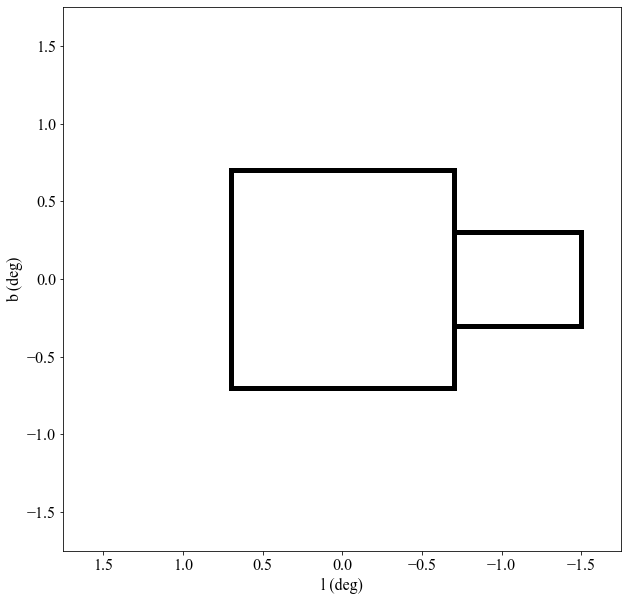

In [16]:
from matplotlib import patches
glon_high_sq = 0.7
glon_low_sq = -0.7
glat_high_sq = 0.7
glat_low_sq = -0.7
glon_high_ra = -0.7
glon_low_ra = -1.5
glat_high_ra = 0.3
glat_low_ra = -0.3
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
ax.set_xlim(1.75, -1.75)
ax.set_ylim(-1.75, 1.75)
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# square region
ax.add_patch(patches.Rectangle((glon_low_sq, glat_low_sq), glon_high_sq-glon_low_sq, glat_high_sq-glat_low_sq, lw=5, fc='black', fill = None))
# rectoangular region
ax.add_patch(patches.Rectangle((glon_low_ra, glat_low_ra), glon_high_ra-glon_low_ra, glat_high_ra-glat_low_ra, lw=5, fc='black', fill = None))


### Mapping 

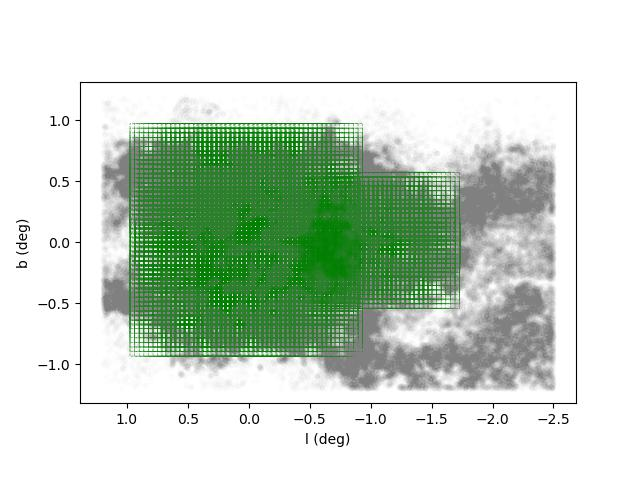

In [59]:
from IPython.display import Image
filename='MPSv2_mappings.jpg'
Image(filename)

## Galactic Centre observation parameter

- Number of orbits for the whole mission = 6,500 (80 % of available orbits for 3 years)
- Altitude = 600 km -> Orbital period = 5,801 s (from Yamada-san, 05 July 2022)
- Observing time per orbit … 98 % of half orbit = 2,842.49 s. (98% comes from JASMINE_HO_TN_HKZ_202206_02_Brief 21/06/2022 in Slack #Soutenken)
- Number of small frame to observer per orbit = 8.  (number of meneuver = 7).
- Number  of orbits to cover the whole large frame field = 214  (computed with MPSv2.py)
- Centoroid measurement accuracy per plate (exposure) = 4 mas


### re-consider the orbits

In [74]:
import astropy.units as u
print(' 1 year (s)=', (1.0*u.yr).cgs)
t_orbit = 5801*u.s  # time for orbit
print(' number of orbit for 3 years =', 3.0*((1.0*u.yr).cgs)/t_orbit)
print(' available for GC survey, i.e. 0.5 year =', 0.5*3.0*((1.0*u.yr).cgs)/t_orbit)
print(' 80 % of available for GC survey, i.e. 0.5 year =', 0.8*0.5*3.0*((1.0*u.yr).cgs)/t_orbit)

 1 year (s)= 31557600.0 s
 number of orbit for 3 years = 16320.082744354422
 available for GC survey, i.e. 0.5 year = 8160.041372177211
 80 % of available for GC survey, i.e. 0.5 year = 6528.03309774177


In [75]:
# compute number of possible exposures (plates) per exposure
t_expro = 13.5   # exposure time + read-out time (s)
t_meneuver = 80   # maneuver time (120 s conservative)
t_obs_orbit = 5801*0.5*0.98  # available observing time for Galactic centre per orbit. 
print(' Tobs per orbit (s) = ', t_obs_orbit )
nsf_orbit = 8  # number of small frame to observe per orbit.
nplate_sf = int((t_obs_orbit-(nsf_orbit-1)*t_meneuver)/t_expro/nsf_orbit)
print(' number of plates per small frame = ',  nplate_sf)
print(' remaining time per orbit = ',  t_obs_orbit-(nplate_sf*nsf_orbit*t_expro+(nsf_orbit-1)*t_meneuver))

 Tobs per orbit (s) =  2842.49
 number of plates per small frame =  21
 remaining time per orbit =  14.489999999999782


- Number of observation per small frame = 21
#### Note: if meneuver time is 120 s (conservative), we need to set 18 plates per small frame.

#### for parallax accuracy, we add a parallax factor of 1.15 (JASMINE-CA-TN-YY-019)

In [76]:
norb_gcf = 214   # Number  of orbits to cover the whole large frame field 
norbits = 6500 # number of orbits in the mission. 
ac_plate = 4000  # accuracy per plate (per exposure) (uas) for star with hw_bright (mag)
hw_bright = 12.5  # bright Hw magnitude to have ac_plate 
Nph_star = 10**(hw/-2.5)/10**(hw_bright/-2.5)
# limit brighter stars' accuracy to the same as the accuracy of hw_bright stars
Nph_star[hw<hw_bright] = 1.0
acc_scale = nplate_sf*(norbits/norb_gcf)
parallax_factor = 1.15 # from JASMINE-CA-TN-YY-019
final_ac = parallax_factor*ac_plate/np.sqrt(nans*acc_scale)/np.sqrt(Nph_star)
print(' highest accuracy (uas)=', np.min(final_ac))
print(' number of observation per the full large frame coverage =', norbits/norb_gcf)
ntobs_star = nans*norbits*nplate_sf/norb_gcf   # total number of observation per star
print(' highest number of observation per star=', np.max(ntobs_star))

 highest accuracy (uas)= 13.009792115454571
 number of observation per the full large frame coverage = 30.373831775700936
 highest number of observation per star= 125018.69158878505


/var/folders/5q/gsgm2rhn60nb_27r7l6gty9w0000gn/T/ipykernel_69337/141420042.py:10: RuntimeWarning: divide by zero encountered in true_divide
  final_ac = parallax_factor*ac_plate/np.sqrt(nans*acc_scale)/np.sqrt(Nph_star)


In [77]:
print(' shape final_ac', final_ac)

 shape final_ac [inf inf inf ... inf inf inf]


#### Histogram of total number of observation per mission.

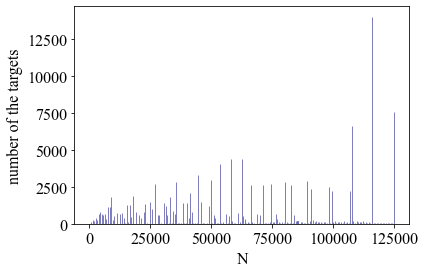

In [90]:
hist_n_targets(ntobs_star)

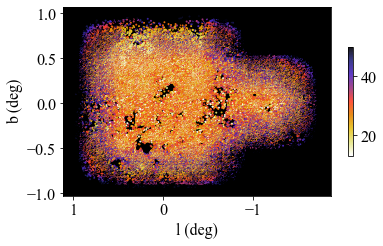

In [78]:
plot_ae_targets(l,b,final_ac,cmap="CMRmap_r")

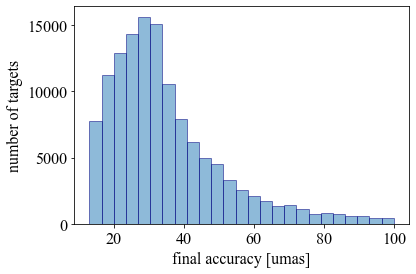

In [79]:
hist_ae_targets(final_ac)

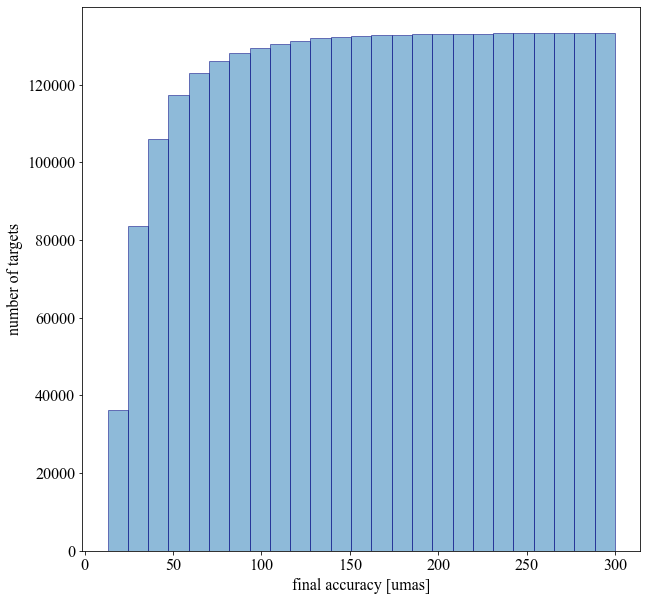

In [80]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
cb=ax.hist(final_ac[final_ac<300.0], alpha=0.5, bins=25, ec='navy', cumulative=True)
ax.set_ylabel("number of targets")
ax.set_xlabel("final accuracy [umas]")
plt.show()


In [81]:
print('number of stars whose astrometric accuracy is better than 17 uas =', np.shape(final_ac[final_ac<17.0]))
print('number of stars whose astrometric accuracy is better than 25 uas =', np.shape(final_ac[final_ac<25.0]))
print('number of stars whose astrometric accuracy is better than 40 uas =', np.shape(final_ac[final_ac<40.0]))
print('number of stars whose astrometric accuracy is better than 37.5 uas =', np.shape(final_ac[final_ac<37.5]))
print('number of stars whose astrometric accuracy is better than 125 uas =', np.shape(final_ac[final_ac<125.0]))

number of stars whose astrometric accuracy is better than 17 uas = (9139,)
number of stars whose astrometric accuracy is better than 25 uas = (38249,)
number of stars whose astrometric accuracy is better than 40 uas = (93455,)
number of stars whose astrometric accuracy is better than 37.5 uas = (87731,)
number of stars whose astrometric accuracy is better than 125 uas = (131167,)


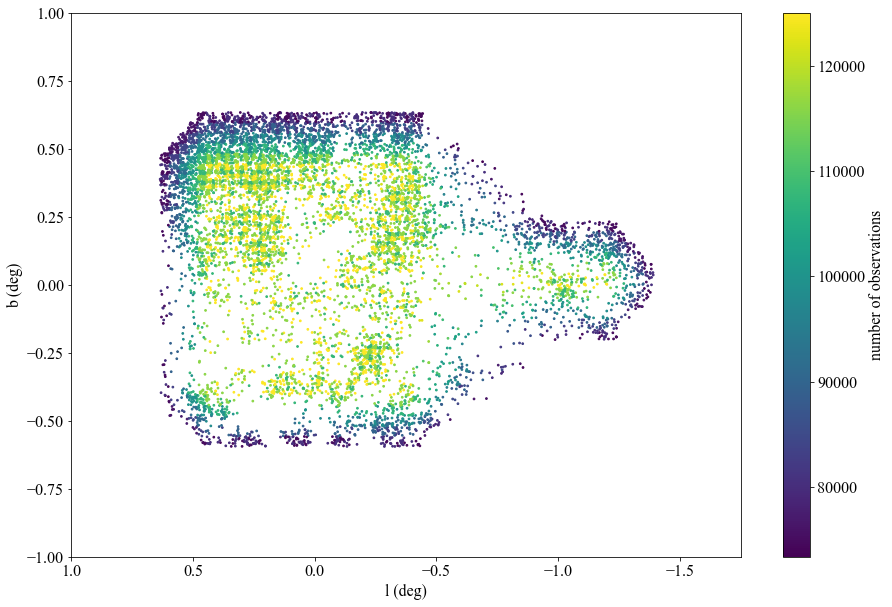

In [102]:
# plot the best accuracy data only
plt.figure(figsize=(15, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
ax.set_xlim(1.0, -1.75)
ax.set_ylim(-1.0, 1.0)
cb = ax.scatter(l[final_ac<17.0], b[final_ac<17.0], s=3, c=ntobs_star[final_ac<17.0], label='number of observations')
cbar = plt.colorbar(cb)
cbar.set_label('number of observations')
ax.set_xlabel("l (deg)")
ax.set_ylabel("b (deg)")
plt.show()

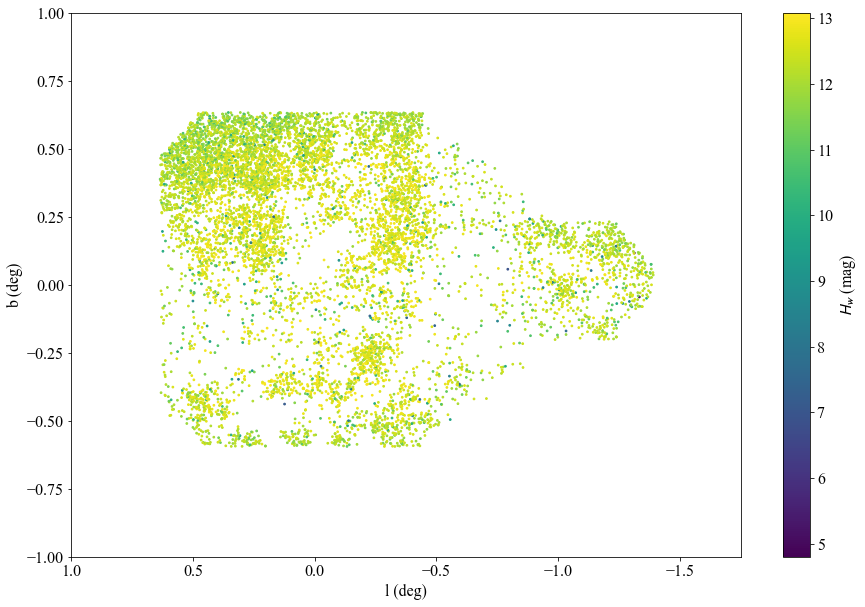

In [103]:
# plot the best accuracy data only
plt.figure(figsize=(15, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
ax.set_xlim(1.0, -1.75)
ax.set_ylim(-1.0, 1.0)
cb = ax.scatter(l[final_ac<17.0], b[final_ac<17.0], s=3, c=hw[final_ac<17.0], label='number of observations')
cbar = plt.colorbar(cb)
cbar.set_label('$H_w$ (mag)')
ax.set_xlabel("l (deg)")
ax.set_ylabel("b (deg)")
plt.show()

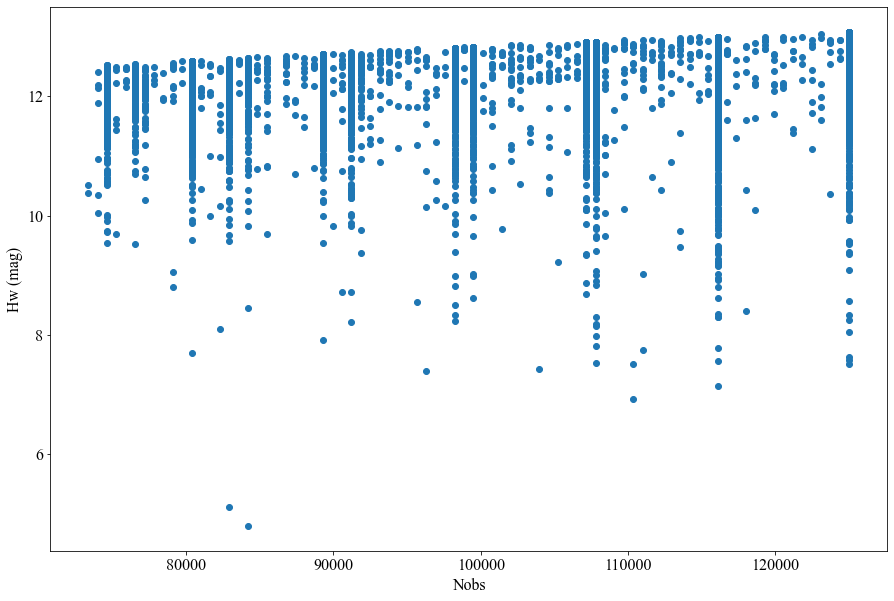

In [105]:
# plot the best accuracy data only
plt.figure(figsize=(15, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
# ax.set_xlim(1.0, -1.75)
# ax.set_ylim(-1.0, 1.0)
ax.scatter(ntobs_star[final_ac<17.0],hw[final_ac<17.0])
ax.set_xlabel("Nobs")
ax.set_ylabel("Hw (mag)")
plt.show()

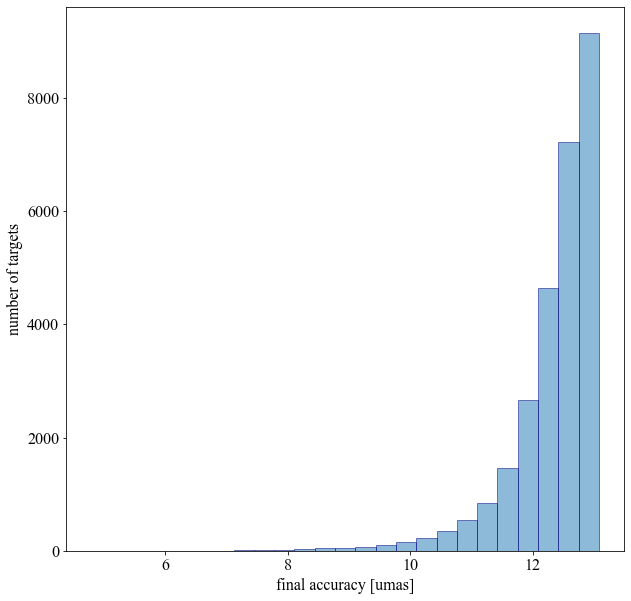

 fantest mag for 17 uas= 13.080561


In [83]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
cb=ax.hist(hw[final_ac<17.0], alpha=0.5, bins=25, ec='navy', cumulative=True)
ax.set_ylabel("number of targets")
ax.set_xlabel("final accuracy [umas]")
plt.show()
print(' fantest mag for 17 uas=', np.max(hw[final_ac<17.0]))

Only select the data with good astrometry accuracy.

In [84]:
ac_limit = 300
ac_ga = final_ac[final_ac<ac_limit]
hw_ga = hw[final_ac<ac_limit]
nans_ga = nans[final_ac<ac_limit]
l_ga = l[final_ac<ac_limit]
b_ga = b[final_ac<ac_limit]
ntobs_star_ga = ntobs_star[final_ac<ac_limit]
print(' number of tolta observed stars =', np.shape(nans_ga))

 number of tolta observed stars = (133233,)


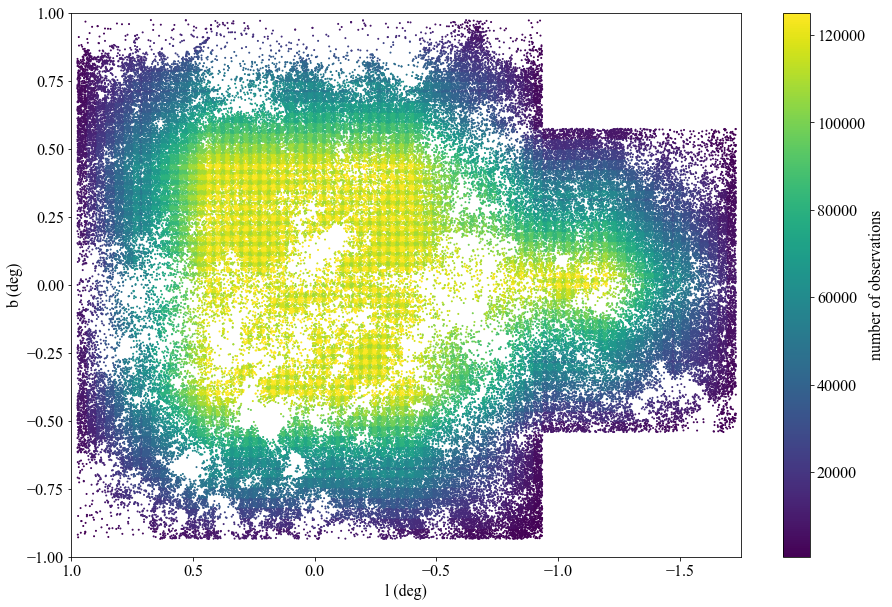

In [85]:
plt.figure(figsize=(15, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
ax.set_xlim(1.0, -1.75)
ax.set_ylim(-1.0, 1.0)
cb = ax.scatter(l_ga, b_ga, s=1, c=ntobs_star_ga, label='number of observations')
cbar = plt.colorbar(cb)
cbar.set_label('number of observations')
ax.set_xlabel("l (deg)")
ax.set_ylabel("b (deg)")
plt.show()

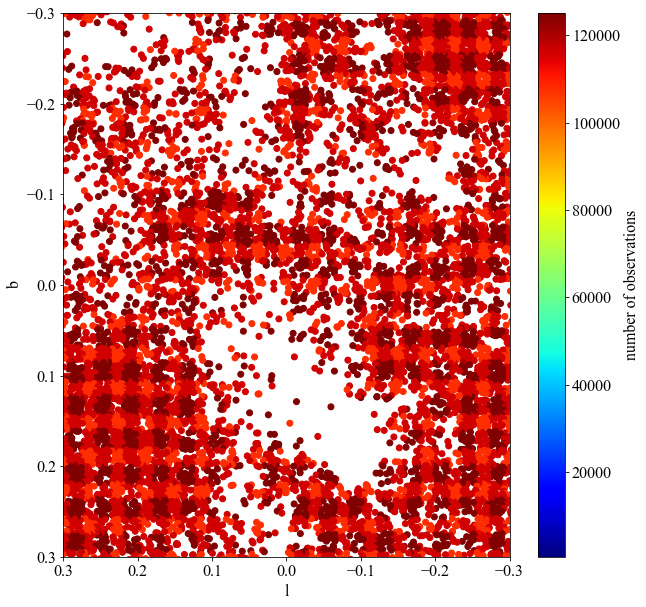

In [94]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
ax.set_xlim(0.3, -0.3)
ax.set_ylim(0.3, -0.3)
cb = ax.scatter(l_ga, b_ga, c=ntobs_star_ga, label='number of observations', cmap='jet')
cbar = plt.colorbar(cb)
cbar.set_label('number of observations')
ax.set_xlabel("l")
ax.set_ylabel("b")
plt.show()

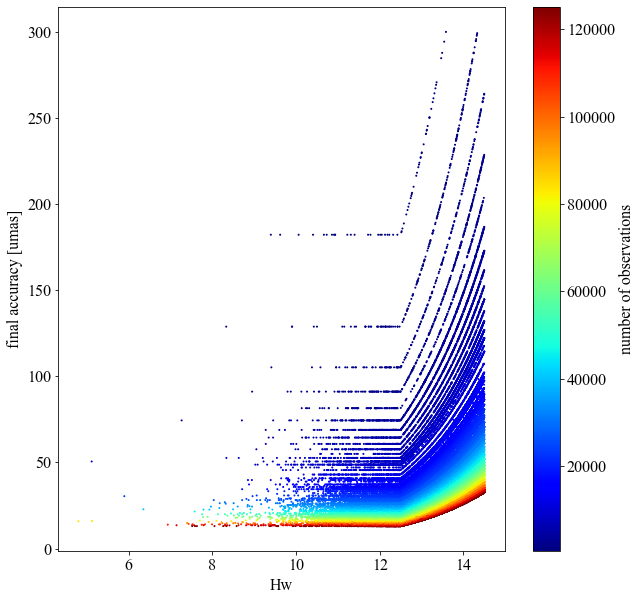

In [93]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
# ax.set_xlim(1.75, -1.75)
# ax.set_ylim(-1.75, 1.75)
cb = ax.scatter(hw_ga, ac_ga, s=1, c=ntobs_star_ga, label='number of observations', cmap='jet')
cbar = plt.colorbar(cb)
cbar.set_label('number of observations')
ax.set_xlabel("Hw")
ax.set_ylabel("final accuracy [umas]")
plt.show()

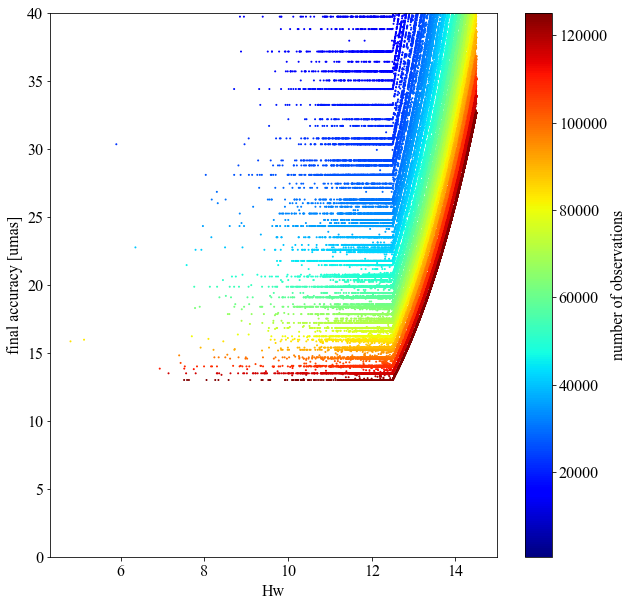

In [92]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
# ax.set_xlim(1.75, -1.75)
ax.set_ylim(0, 40)
cb = ax.scatter(hw_ga, ac_ga, s=1, c=ntobs_star_ga, label='number of observations', cmap='jet')
cbar = plt.colorbar(cb)
cbar.set_label('number of observations')
ax.set_xlabel("Hw")
ax.set_ylabel("final accuracy [umas]")
plt.show()

Plot the distribution of stars whose astrometric accuracy is better than 25 $\mu$as. 

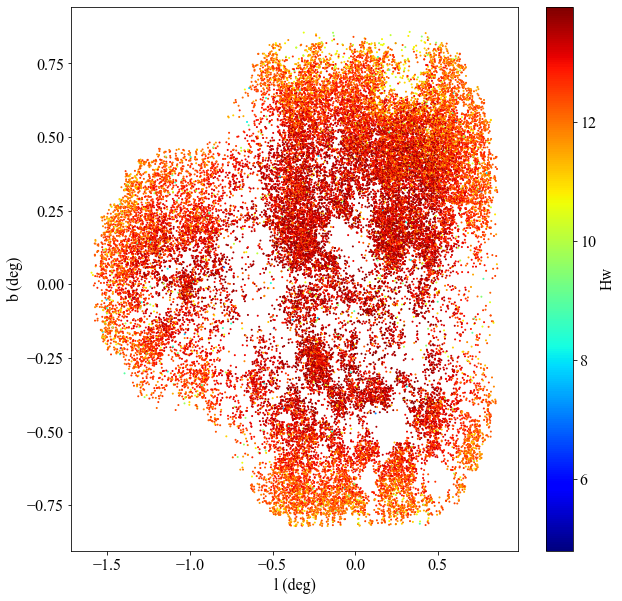

In [89]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["font.size"] = 16
ax  = plt.gca()
# ax.tick_params(labelsize=16, color='k', direction="in")
# ax.set_xlim(1.75, -1.75)
# ax.set_ylim(-1.75, 1.75)
cb = ax.scatter(l_ga[ac_ga<25.0], b_ga[ac_ga<25.0], s=1, c=hw_ga[ac_ga<25.0],  cmap='jet')
cbar = plt.colorbar(cb)
cbar.set_label('Hw')
ax.set_xlabel("l (deg)")
ax.set_ylabel("b (deg)")
plt.show()